In [1]:
import os.path as osp
import os
os.chdir('/mnt/data/akshit.jain/user_clicks/')

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
df=pd.read_pickle('data_df.pk')

#### filter entries to contain fsns that we have images for

In [7]:
!ls ../visual_reco/

bpr-model   ctrsr_datasets	ctrsr_datasets.zip  tshirt_image_urls.tsv
checkpoint  ctrsr_datasets.rar	product_images


In [3]:
fsn_images=os.listdir('../visual_reco/product_images/')
fsns=[image.split('.')[0] for image in fsn_images]

In [4]:
fsns=pd.Series(fsns)
image_fsn_clicks=df[df.fsn.isin(fsns)]

In [5]:
print("user clicks reduced to {} from {}".format(image_fsn_clicks.shape[0],df.shape[0]))

user clicks reduced to 92614 from 92614


### extract image features

In [6]:
fsns=image_fsn_clicks.fsn.unique()

In [7]:
# incase of corrupted images. identify from
! ls -lrS ../visual_reco/product_images/ | head

total 870144
-rw-rw-r-- 1 akshit.jain akshit.jain   2071 Aug 28 10:29 SHTEW7KZZ7CXSPUV.jpg
-rw-rw-r-- 1 akshit.jain akshit.jain   2071 Aug 28 10:29 SHTEW7KZHVZXP59K.jpg
-rw-rw-r-- 1 akshit.jain akshit.jain   2071 Aug 28 10:34 SHTE4XEBFBRXGGWN.jpg
-rw-rw-r-- 1 akshit.jain akshit.jain   2074 Aug 24 12:39 SHTF6NSUR8W5XZPS.jpg
-rw-rw-r-- 1 akshit.jain akshit.jain   2074 Aug 24 10:38 SHTF47JUZUK6KW9T.jpg
-rw-rw-r-- 1 akshit.jain akshit.jain   2074 Aug 24 10:39 SHTF47JUYH7QTQWT.jpg
-rw-rw-r-- 1 akshit.jain akshit.jain   2074 Aug 24 10:39 SHTF47JUVAFWZUNR.jpg
-rw-rw-r-- 1 akshit.jain akshit.jain   2074 Aug 24 10:40 SHTF47JUMS9ZK8BF.jpg
-rw-rw-r-- 1 akshit.jain akshit.jain   2075 Aug 24 10:37 SHTFYSFPBA3K2VDH.jpg
ls: write error: Broken pipe


In [8]:
def preprocess_image(image_file, width=224, height=224):
    image_encoded = tf.read_file(image_file)
    image = tf.image.decode_image(image_encoded, channels=3, dtype=tf.float32)
    image = tf.Print(image, [image], message="preprocessing image")
    image_padded = tf.image.resize_image_with_pad(image, target_height=height, target_width=width)
    image_padded.set_shape(shape=(width, height, 3))
    return image_padded

def compute_without_batch(images, module):
    embs = module(images)# tf.map_fn(module, images, back_prop=False)
    return embs.eval()

def compute_with_batch_low(images, module):
    image_batches=tf.train.batch([images], batch_size=10, enqueue_many=True, allow_smaller_final_batch=True)
    tf.train.start_queue_runners()
    return module(image_batches).eval()
    #emb_batches = tf.map_fn(module, image_batches, back_prop=False)
    #return emb_batches.eval()
    
def get_image_embeddings(image_files_list):
    with tf.Graph().as_default():
        # load and batch images
        file_paths_tensor = tf.convert_to_tensor(image_files_list, dtype=tf.string)
        file_paths_queue = tf.train.string_input_producer(file_paths_tensor, num_epochs=1, shuffle=False)
        image_file_path = file_paths_queue.dequeue()
        image = preprocess_image(image_file_path)

        images=tf.train.batch([image], batch_size=1000, allow_smaller_final_batch=True)

        # load module
        NASNET_MOBILE='https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/1'
        module = hub.Module(NASNET_MOBILE)
        tf.logging.info('module loaded')
        #expected_width, expected_height= hub.get_expected_image_size(module)

        embs = module(images)
        
        config = tf.ConfigProto()
        config.gpu_options.allow_growth=True
        with tf.Session(config=config) as sess:
            sess.run(tf.local_variables_initializer())
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())
            tf.logging.info('globals initiated')
            
            tf.train.start_queue_runners()
            
            embs_list = []
            try:
                while True:
                    _embs = embs.eval()
                    tf.logging.info(_embs.shape)
                    embs_list.append(_embs)
            except tf.errors.OutOfRangeError:
                tf.logging.info('all embs computed')
            sess.close()
            return np.vstack(embs_list)

def get_fsns_embeddings(fsns):
    image_data_dir='/mnt/data/akshit.jain/visual_reco/product_images/'
    fsn_images = [osp.join(image_data_dir, fsn+'.jpg') for fsn in fsns]
    return get_image_embeddings(fsn_images)
# embs=get_image_embeddings(fsn_images)

# prepare data

In [9]:
def prepare_data(df):
    df = df[['fsn','userId']].sample(frac=1.0)
    df.reset_index(inplace=True, drop=True)
    unique_users = pd.Series(df.userId.unique()).to_frame('userId')
    unique_users['id']=unique_users.index
    unique_fsns = pd.Series(df.fsn.unique()).to_frame('fsn')
    unique_fsns['id']=unique_fsns.index
    denorm_df=pd.merge(df, unique_fsns, how='inner', on='fsn').merge(unique_users, on='userId', suffixes=('_fsn', '_user'))
    return denorm_df, unique_fsns, unique_users

In [10]:
clicks, fsns, users = prepare_data(image_fsn_clicks)

In [11]:
fsn_embs=get_fsns_embeddings(fsns.fsn.values)
fsns['embs']=fsn_embs.tolist()

Instructions for updating:
Use the `axis` argument instead
INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:module loaded
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:globals initiated
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(446, 1056)
INFO:tensorflow:all embs computed


In [14]:
data_dir='openrec_visual_feed_data'
# os.mkdir(data_dir)

In [15]:
clicks.to_pickle(data_dir+'/clicks.pk')
users.to_pickle(data_dir+'/users.pk')
fsns.to_pickle(data_dir+'/items.pk')

### record format of all data

In [16]:
from openrec.utils import ImplicitDataset
from openrec import ImplicitModelTrainer
from openrec.recommenders import VisualPMF
from openrec.utils.evaluators import AUC, Recall
from openrec.utils.samplers import PointwiseSampler

batch_size = 1000
test_batch_size = 100
item_serving_size = 1000
display_itr = 10000

tf.reset_default_graph()

train_clicks_dat=np.asarray(clicks.rename(columns={'id_fsn':'item_id','id_user':'user_id'}).to_records(index=False))
item_v_feature = fsn_embs
train_dataset = ImplicitDataset(raw_data=train_clicks_dat, 
                        max_user=users.shape[0], 
                        max_item=fsns.shape[0], name='Train')

model = VisualPMF(batch_size=batch_size, max_user=train_dataset.max_user(), max_item=train_dataset.max_item(), l2_reg=0.001, l2_reg_mlp=0.001, 
    dropout_rate=0.5, dim_embed=50, item_f_source=item_v_feature, dims=[1028, 128, 50], opt='Adam')
sampler = PointwiseSampler(batch_size=batch_size, dataset=train_dataset, pos_ratio=0.2, num_process=5)
model_trainer = ImplicitModelTrainer(batch_size=batch_size, test_batch_size=test_batch_size, item_serving_size=item_serving_size,
    train_dataset=train_dataset, model=model, sampler=sampler)

auc_evaluator = AUC()

model_trainer.train(num_itr=int(1e5), display_itr=display_itr,evaluators=[auc_evaluator], num_negatives=1000)


Instructions for updating:
keep_dims is deprecated, use keepdims instead


[Subsampling negative items]
== Start training with sampled evaluation, sample size: 1000 ==


[Itr 1000] Finished
[Itr 2000] Finished
[Itr 3000] Finished
[Itr 4000] Finished
[Itr 5000] Finished
[Itr 6000] Finished
[Itr 7000] Finished
[Itr 8000] Finished
[Itr 9000] Finished
[Itr 10000] Finished
[Itr 10000] loss: 43.570414
[Itr 11000] Finished
[Itr 12000] Finished
[Itr 13000] Finished
[Itr 14000] Finished
[Itr 15000] Finished
[Itr 16000] Finished
[Itr 17000] Finished
[Itr 18000] Finished
[Itr 19000] Finished
[Itr 20000] Finished
[Itr 20000] loss: 22.389405
[Itr 21000] Finished
[Itr 22000] Finished
[Itr 23000] Finished
[Itr 24000] Finished
[Itr 25000] Finished
[Itr 26000] Finished
[Itr 27000] Finished
[Itr 28000] Finished
[Itr 29000] Finished
[Itr 30000] Finished
[Itr 30000] loss: 15.768704
[Itr 31000] Finished
[Itr 32000] Finished
[Itr 33000] Finished
[Itr 34000] Finished
[Itr 35000] Finished
[Itr 36000] Finished
[Itr 37000] Finished
[Itr 38000] Finished
[Itr 39000] Finished
[Itr 40000] Finished
[Itr 40000] loss: 12.172984
[Itr 41000] Finished
[Itr 42000] Finished
[Itr 43000] Fin

In [17]:
model.save('./visual-pmf-all',10)

INFO:tensorflow:./visual-pmf-all-10 is not in all_model_checkpoint_paths. Manually adding it.


In [143]:
fsns=pd.read_pickle(data_dir+'/items.pk')

fsn_image_meta=pd.read_pickle('../visual_reco/tshirt_image_urls_all.pk')
fsn_meta=pd.merge(fsns, fsn_image_meta[['fsn','url']], on='fsn', how='left')
import re
def extract_title(url):
    return ' '.join([tok for tok in url.split('/')[-1].split('-') if re.match('^[a-z]{2,}$', tok)][:-1])
fsn_meta['title']=fsn_meta.url.apply(extract_title)

In [164]:
fsn_meta.to_pickle('fsn_meta.pk')

## Test the model

In [144]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.rcParams['figure.figsize'] = [17, 20]


IMAGE_DIR='../visual_reco/product_images/'
def plot_images(_fsns):
    _fsns=list(_fsns)
    imgs=[mpimg.imread(osp.join(IMAGE_DIR, f+'.jpg')) for f in _fsns]
    N_COLS=5#min(len(fsns),5)
    N_ROWS=(len(_fsns)+N_COLS-1)//N_COLS
    PLOT_WIDTH=17
    PLOT_HEIGHT=1.5*int(N_ROWS*(PLOT_WIDTH/N_COLS))
    f, axarr = plt.subplots(N_ROWS, N_COLS, squeeze=False, figsize=(PLOT_WIDTH,PLOT_HEIGHT))
    [(ax.get_xaxis().set_visible(False), ax.get_yaxis().set_visible(False), ax.axis('off')) for ax in f.axes]
    
    f.tight_layout()
    for idx, fsn in enumerate(_fsns):
        plt.axis('off')
        plot_row = idx//N_COLS
        plot_col = idx%N_COLS
        axarr[plot_row,plot_col].imshow(imgs[idx])
        title=fsn_meta[fsn_meta.fsn==_fsns[idx]].iloc[0].title
        axarr[plot_row,plot_col].set_title(title)
    #plt.savefig('similar_demo_3.png')
    plt.show()
    
from random import randint

def print_uris(dbg_fsn):
    for x in dbg_fsn:
        print("http://www.flipkart.com/item/{}".format(x))

In [168]:
# highlander checks: 17904
# mufti : 6666
# louis philippe: 9224
# denim wrangler: 6592
DBG_USER=6666#np.random.randint(users.shape[0])
print("user id: {}".format(DBG_USER))
dat=train_clicks_dat
dat[dat['user_id']==DBG_USER]

in_dat=np.array([(DBG_USER,x) for x in range(fsns.shape[0])], dtype=[('user_id_input', 'i8'),('item_id_input', 'i8')])
scores=model.serve(in_dat)[0]
top_n=np.argsort(-scores)[:20]
clicked_fsn = clicks[clicks.id_user==DBG_USER].fsn.unique()
rec_fsn = frozenset(fsns.fsn.iloc[top_n].values)-frozenset(clicked_fsn)

user id: 6666


### all clicked

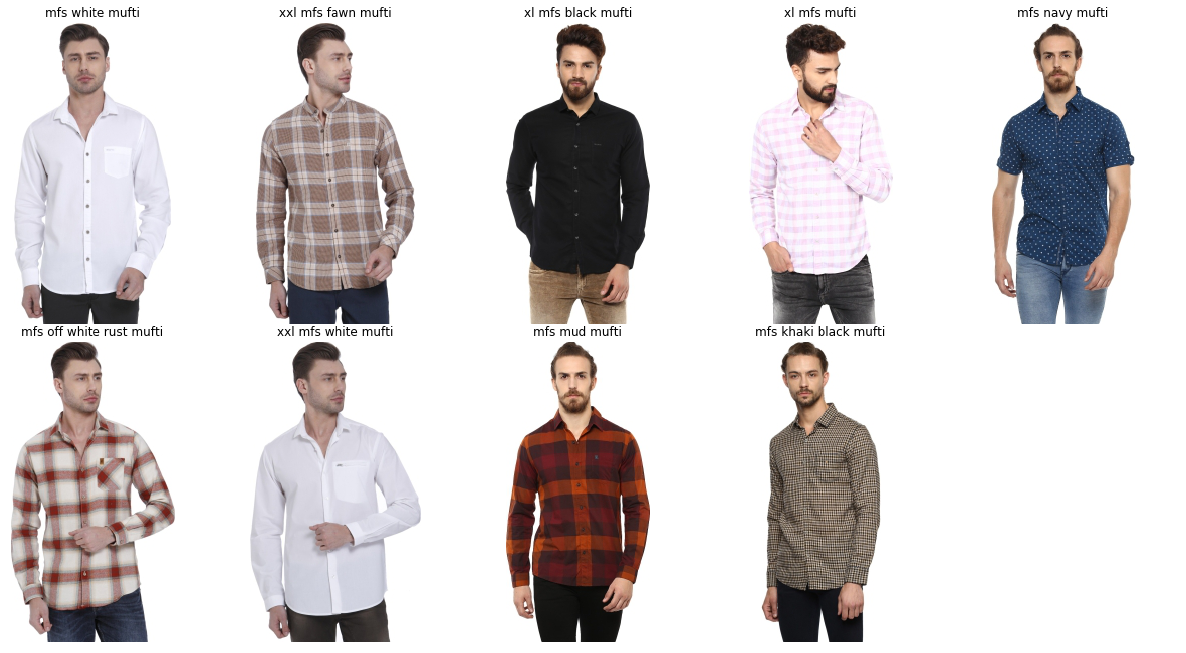

In [169]:
# print_uris(clicked_fsn)
plot_images(clicked_fsn)

### top 20 recommended

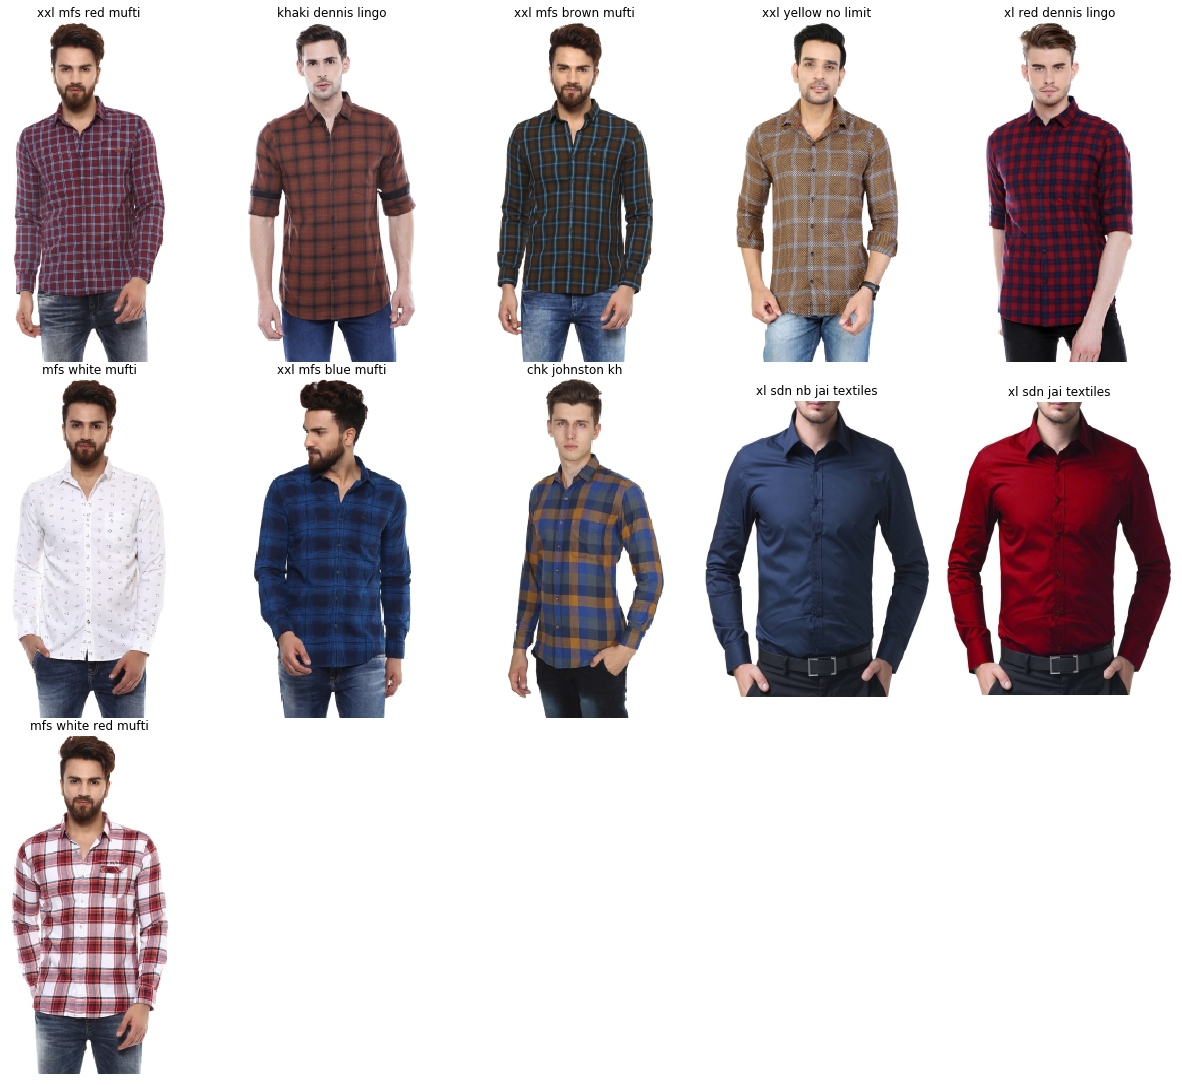

In [170]:
# print_uris(rec_fsn)
plot_images(rec_fsn)

In [196]:
# fsn_meta[fsn_meta.title.str.contains('denim')]

In [195]:
# clicks[clicks.fsn=='SHTF4P674AXGFZCD']

## Get user or item vector

In [194]:
in_dat=np.array([(0,0)], dtype=[('user_id_input', 'i8'),('item_id_input', 'i8')])
double=model.compute_module_outputs('item_vec', in_dat, train=False)